# Comparitive Reafference

This code learns effects as correlation, then attributes exafference to any error in the prediction of reafference. Learning the correlation between action and effect will include any exafferent effects (e.g effects due to gravity). Exafference is introduced after training by changing the pole length.


In [1]:
import gym
import numpy as np
import torchinfo
import torch
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from reafference.environment.cartpole import make, ground_truth, get_images, make_episode, make_dataset, plot # if error install local repo
from reafference.model import CartPoleNet
DEVICE = "cuda:0"

env = make(render=False, angle_threshold=float("inf"), euler=True)

state_shape = env.observation_space.shape
action_shape = (env.action_space.n,)
latent_shape = (512,)
epochs = 50

model = CartPoleNet(state_shape, action_shape, latent_shape).to(DEVICE)
optim = torch.optim.Adam(model.parameters(), lr=0.0005)
criterion = torch.nn.MSELoss()


/home/ben/anaconda3/envs/reaff/lib/python3.8/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/ben/anaconda3/envs/reaff/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


In [3]:
# train the model on the environment
env = make(render=False, angle_threshold=float("inf"), euler=True) 
dataset = make_dataset(env, num_episodes=250, device=DEVICE)
loader = DataLoader(dataset, batch_size=1028, shuffle=True, drop_last=False)
epoch_iter = tqdm(range(epochs))
for e in epoch_iter:
    avg_loss = []
    for x1, x2, a in loader:
        optim.zero_grad()
        pred_effect = model(x1, a)        
        total_effect = x2 - x1
        loss = criterion(pred_effect, total_effect)
        loss.backward()
        avg_loss.append(loss.detach())
        optim.step()
    avg_loss = torch.stack(avg_loss).cpu().numpy().mean()
    epoch_iter.set_description(f"Training Loss: {avg_loss : .5f}") 

  0%|          | 0/50 [00:00<?, ?it/s]

Prediction Error: 0.00069207797


(-0.5112762480974198, 0.4946014314889908)

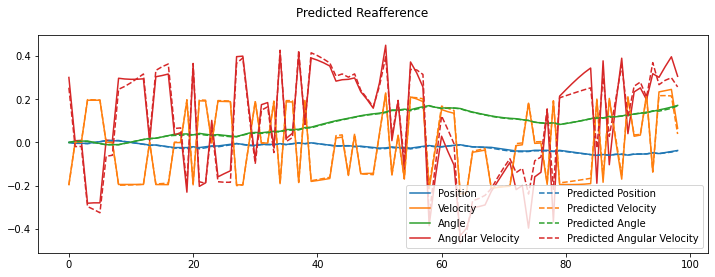

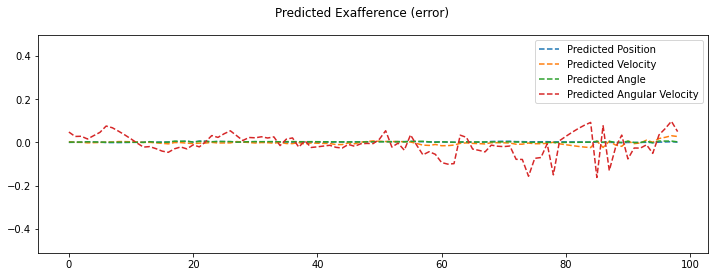

In [6]:
# Show reafferent prediction in the training environment. 
# This is analogous to the bi-pedal robot training on a flat surface.
env = make(render=False, angle_threshold=float("inf"), euler=True) 
dataset = make_dataset(env, num_episodes=1, max_episode_length=100, device=DEVICE)
x1, x2, a = zip(*dataset)
x1, x2, a = torch.stack(x1), torch.stack(x2), torch.stack(a)
total_effect = (x2 - x1)
pred_effect = model(x1, a)

fig = plt.figure(figsize=(12,4))
fig.suptitle("Predicted Reafference")
plot(total_effect.cpu().numpy(), style="-", fig=fig)
plt.gca().set_prop_cycle(None)
plot(pred_effect.detach().cpu().numpy(), style="--", fig=fig, label_prefix="Predicted ")
plt.legend(loc='lower right', ncol=2)
print("Prediction Error:", criterion(pred_effect, total_effect).detach().cpu().numpy())
ylim1, ylim2 = plt.gca().get_ylim()

# The error here is due to the models epistemic uncertainty, there are no exafferent effects in reality.
fig = plt.figure(figsize=(12,4))
fig.suptitle("Predicted Exafference (error)")
plot((total_effect - pred_effect).detach().cpu().numpy(), style="--", fig=fig, label_prefix="Predicted ")
plt.gca().set_ylim(ylim1, ylim2)


Prediction Error: 0.015444014
Initial Pole Length: 0.500
Final Pole Length: 0.200


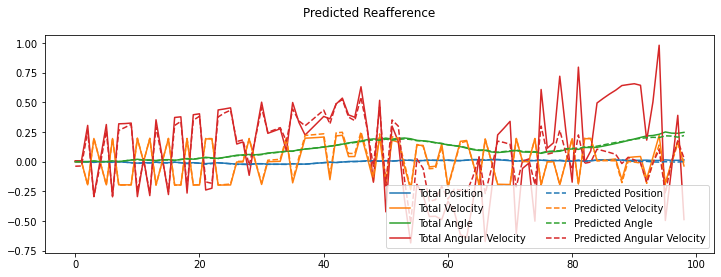

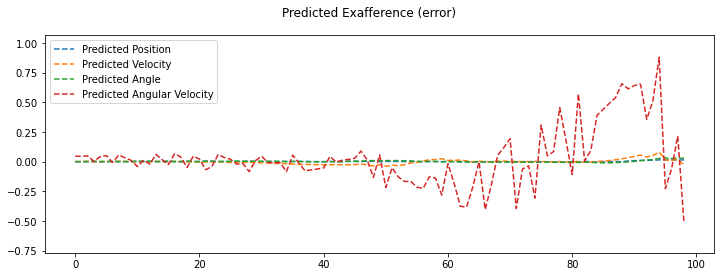

In [8]:
# Show the reafferent prediction and exafferent error in another environment with a different pole length.
# This is analogous to the bi-pedal robot testing in a sloped environment. The slope being the source of exafference.
# Here the differing pole length is the source of exafference (error). 
# The pole length changes by a small amount at each step leading gradually increasing error and so also exafference.

class LengthWrapper(gym.Wrapper): # this wrapped gradually changes the length of the pole over an episode
    def __init__(self, env, dl=0.002):
        super().__init__(env)
        self.dl = dl
        self._initial_pole_length = self.env.unwrapped.length
    def step(self, action):
        self.env.unwrapped.length += self.dl
        self.env.unwrapped.polemass_length = self.env.unwrapped.masspole * self.env.unwrapped.length
        return super().step(action)
    def reset(self):
        self.env.unwrapped.length = self._initial_pole_length
        return super().reset()
        
env = make(render=False, angle_threshold=float("inf"), euler=True)
env = LengthWrapper(env, dl=-0.003)

dataset = make_dataset(env, num_episodes=1, max_episode_length=100, device=DEVICE)
x1, x2, a = zip(*dataset)
x1, x2, a = torch.stack(x1), torch.stack(x2), torch.stack(a)

total_effect = (x2 - x1)
pred_effect = model(x1, a)

fig = plt.figure(figsize=(12,4))
fig.suptitle("Predicted Reafference")
plot(total_effect.cpu().numpy(), style="-", fig=fig, label_prefix="Total ")
plt.gca().set_prop_cycle(None)
plot(pred_effect.detach().cpu().numpy(), style="--", fig=fig, label_prefix="Predicted ")
plt.legend(loc='lower right', ncol=2)
print("Prediction Error:", criterion(pred_effect, total_effect).detach().cpu().numpy())
ylim1, ylim2 = plt.gca().get_ylim()

# The error here is due to both the models epistemic uncertainty and the new environment.
fig = plt.figure(figsize=(12,4))
fig.suptitle("Predicted Exafference (error)")
plot((total_effect - pred_effect).detach().cpu().numpy(), style="--", fig=fig, label_prefix="Predicted ")
plt.gca().set_ylim(ylim1, ylim2)

print(f"Initial Pole Length: {env._initial_pole_length :0.3f}")
print(f"Final Pole Length: {env.unwrapped.length :0.3f}")

